In [1]:
from log_parser_lib import *
import os
import pickle as pkl
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from numpy import log as ln
from math import log, sqrt
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Read Data

In [2]:
with open('data.pkl','rb') as f:
    data=pkl.load(f)
(log_dict, synant_dict, log_patterns,event_list),(Q, sigma, delta, initialState, F_) = data
print(f'event num is {len(event_list)}')

normal_log_path='../log_dpnm_tb'
log_data=[]
norm_num=0
date_list=os.listdir(normal_log_path)
for date in date_list:
    if os.path.isfile(normal_log_path+'/'+date):
        continue
    log_=read_file(normal_log_path+'/'+date+'/all.log')
    if log_:
        log_data.append(log_)
        norm_num+=1
print(f'{norm_num} of normal data readed')
assert(norm_num==len(log_data))

event num is 50
18 of normal data readed


# Calculate Log-TF-IDF

In [3]:
# add all value in log_patterns dictionary
num_all_log=sum(single_log[1] for single_log in log_patterns)
num_all_doc=len(log_data)+2

# let's calcurate tf-idf of all patterns
tf_idf=[0 for _ in range(len(log_patterns))]
for single_file_data in log_data:
    tmp_df=[False for _ in range(len(log_patterns))]
    for single_log in single_file_data:
        single_pattern=log_parser(single_log, log_dict)
        if single_pattern==[]:continue
        tmp_df[find_pattern_num(single_pattern,log_patterns)-1]=True
    for i in range(len(tmp_df)):
        if tmp_df[i]:
            tf_idf[i]+=1
df=tf_idf[:]
tf=[]
idf=[]
for i in range(len(tf_idf)):
    tf.append(ln(num_all_log/(1+log_patterns[i][1])))
    idf.append(num_all_doc/(1+tf_idf[i]))
    tf_idf[i]=ln(tf[i]*idf[i])
print(f'tf-idf of all patterns are calculated')
print(f'averagae of tf-idf is {sum(tf_idf)/len(tf_idf)} and std is {sum((tf_idf[i]-sum(tf_idf)/len(tf_idf))**2 for i in range(len(tf_idf)))/len(tf_idf)}, max is {max(tf_idf)}, min is {min(tf_idf)}')
print(f'average of tf is {sum(tf)/len(tf)} and std is {sum((tf[i]-sum(tf)/len(tf))**2 for i in range(len(tf)))/len(tf)} and max is {max(tf)} and min is {min(tf)}')
print(f'average of idf is {sum(idf)/len(idf)} and std is {sum((idf[i]-sum(idf)/len(idf))**2 for i in range(len(idf)))/len(idf)} and max is {max(idf)} and min is {min(idf)}')

tf-idf of all patterns are calculated
averagae of tf-idf is 3.7691722434651798 and std is 0.930486217343459, max is 4.754632437814264, min is 1.531177401912
average of tf is 8.26465304446208 and std is 9.241679855628224 and max is 11.61209636441463 and min is 3.0135075347943983
average of idf is 6.6090818453729705 and std is 9.258310665967919 and max is 10.0 and min is 1.1764705882352942


In [4]:
log_patterns

[(('root', 'cmd', 'newsyslog', '[number]'), 1445),
 (('root', 'cmd', '[path]'), 4337),
 (('root', 'cmd', 'adjkerntz', 'a'), 180),
 (('nsswitch',
   'nsdispatch',
   'vrf',
   'hosts',
   'getaddrinfo',
   'not',
   'found',
   'and',
   'no',
   'fallback',
   'provided'),
  1683),
 (('nsswitch',
   'nsdispatch',
   'vrf',
   'hosts',
   'gethostbyaddr',
   'r',
   'not',
   'found',
   'and',
   'no',
   'fallback',
   'provided'),
  1689),
 (('connection', 'from'), 1683),
 (('bl',
   'init',
   'connect',
   'failed',
   'for',
   '[path]',
   'sock',
   'no',
   'such',
   'file',
   'or',
   'directory'),
  1683),
 (('anonymous', 'ftp', 'login', 'refused', 'from'), 214),
 (('pam', 'sm', 'authenticate', 'debug', 'pam', 'user', 'www'), 100),
 (('pam',
   'sm',
   'authenticate',
   'debug',
   'updating',
   'lock',
   'attempts',
   'of',
   'user',
   'www',
   'attempts'),
  100),
 (('ftp', 'login', 'failed', 'from'), 1341),
 (('ftp', 'login', 'failed', 'from', 'www'), 100),
 (('p

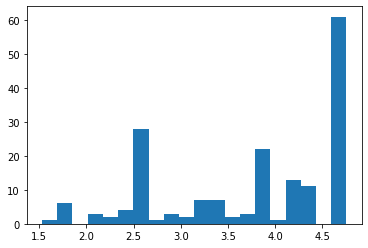

In [5]:
plt.hist(tf_idf, bins=20)
plt.show()

In [6]:
len(tf_idf)

177

In [7]:
num_=0
for i, log_pattern in enumerate(log_patterns):
    if tf_idf[i]>1.9:
        print(' '.join(log_pattern[0])+': '+str(tf[i]))
        num_+=1
print(num_)

root cmd adjkerntz a: 7.1067465137087495
anonymous ftp login refused from: 6.934605516846912
pam sm authenticate debug pam user www: 7.690123028133316
pam sm authenticate debug updating lock attempts of user www attempts: 7.690123028133316
ftp login failed from: 5.103327227442948
ftp login failed from www: 7.690123028133316
pam sm authenticate debug pam user admin: 7.027128885744058
pam sm authenticate debug updating lock attempts of user admin attempts: 7.027128885744058
ftp login failed from admin: 7.027128885744058
pam sm authenticate debug pam user root: 3.828664036443635
pam sm authenticate debug updating lock attempts of user root attempts: 3.828664036443635
ftp login failed from root: 7.794384038457725
pam sm authenticate debug pam user db: 7.543069610176819
pam sm authenticate debug updating lock attempts of user db attempts: 7.543069610176819
ftp login failed from db: 7.543069610176819
pam sm authenticate debug pam user wwwroot: 7.476929807672274
pam sm authenticate debug upda

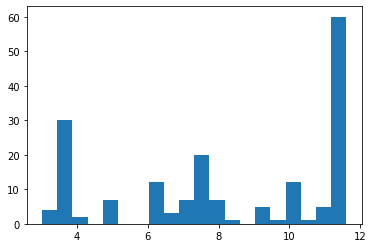

In [8]:
plt.hist(tf, bins=20)
plt.show()

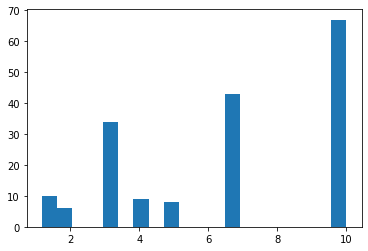

In [9]:
plt.hist(idf, bins=20)
plt.show()

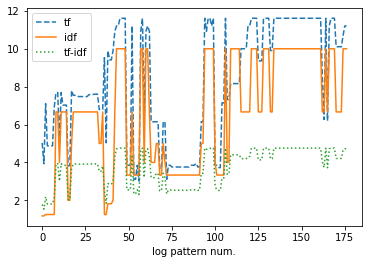

In [10]:
x=range(len(tf_idf))
plt.plot(x, tf, '--', label='tf')
plt.plot(x, idf, '-', label='idf')
plt.plot(x, tf_idf, ':', label='tf-idf')
plt.legend()
plt.xlabel('log pattern num.')
plt.show()

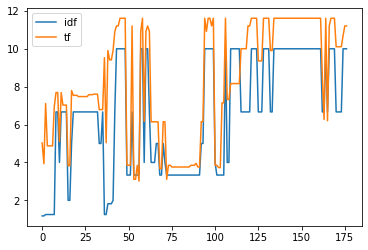

In [11]:
x=range(len(idf))
plt.plot(x, idf, label='idf')
plt.plot(x, tf, label='tf')
plt.legend()
plt.show()

In [12]:
def calculate_tf_idf(log_data, log_patterns):
    # add all value in log_patterns dictionary
    num_all_log=sum(single_log[1] for single_log in log_patterns)
    num_all_doc=len(log_data)+2

    # let's calcurate tf-idf of all patterns
    tf_idf=[0 for _ in range(len(log_patterns))]
    for single_file_data in log_data:
        tmp_df=[False for _ in range(len(log_patterns))]
        for single_log in single_file_data:
            single_pattern=log_parser(single_log, log_dict)
            if single_pattern==[]:continue
            tmp_df[find_pattern_num(single_pattern,log_patterns)-1]=True
        for i in range(len(tmp_df)):
            if tmp_df[i]:
                tf_idf[i]+=1
    df=tf_idf[:]
    tf=[]
    idf=[]
    for i in range(len(tf_idf)):
        tf.append(ln(num_all_log/(1+log_patterns[i][1])))
        idf.append(num_all_doc/(1+tf_idf[i]))
        tf_idf[i]=sqrt(tf[i]*idf[i])
    print(f'tf-idf of all patterns are calculated')
    print(f'averagae of tf-idf is {sum(tf_idf)/len(tf_idf)} and std is {sum((tf_idf[i]-sum(tf_idf)/len(tf_idf))**2 for i in range(len(tf_idf)))/len(tf_idf)}, max is {max(tf_idf)}, min is {min(tf_idf)}')
    print(f'average of tf is {sum(tf)/len(tf)} and std is {sum((tf[i]-sum(tf)/len(tf))**2 for i in range(len(tf)))/len(tf)} and max is {max(tf)} and min is {min(tf)}')
    print(f'average of idf is {sum(idf)/len(idf)} and std is {sum((idf[i]-sum(idf)/len(idf))**2 for i in range(len(idf)))/len(idf)} and max is {max(idf)} and min is {min(idf)}')
    return tf_idf, num_all_doc

### Check the logs with high Log-TF-IDF

In [13]:
with open('data.pkl','rb') as f:
    data=pkl.load(f)
(log_dict, synant_dict, log_patterns,event_list),(Q, sigma, delta, initialState, F_) = data
print(len(idf), len(log_patterns))
num_=0
for i, log_pattern in enumerate(log_patterns):
    if tf_idf[i]>4.5:
        print(' '.join(log_pattern[0])+': '+str(tf_idf[i]))
        num_+=1
print(num_)

177 177
connection reset by port: 4.719090772542918
connection reset by port preauth: 4.719090772542918
pam sm authenticate debug pam user dpnm: 4.754632437814264
pam sm authenticate debug updating lock attempts of user dpnm attempts: 4.754632437814264
error pam authentication error for dpnm from: 4.754632437814264
sshd login failed login failed for user dpnm from host: 4.754632437814264
ge [path] promiscuous mode enabled: 4.693084830095802
ui cmdline read line user root command monitor traffic: 4.754632437814264
ge [path] promiscuous mode disabled: 4.693084830095802
ui cmdline read line user root command monitor traffic [UNK]: 4.719090772542918
ifinfo ifd name ifd ge: 4.754632437814264
ifinfo ifd name ifd ge [path]: 4.693084830095802
ui cmdline read line user root command monitor interface [interface] [path]: 4.754632437814264
ui cmdline read line user root command [UNK] monitor: 4.754632437814264
ui cmdline read line user root command show log [UNK]: 4.719090772542918
ui cmdline read

### Check the Frequency and DF tendancy

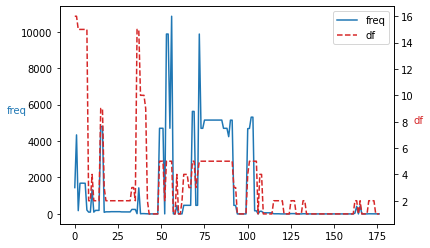

In [14]:
y=[]
for i in range(len(df)):
    y.append(log_patterns[i][1])
    
fig, ax1 = plt.subplots()
ln1=ax1.plot(x,y,label='freq')
ax1.set_ylabel('freq', color='tab:blue',rotation=0)

ax2=ax1.twinx()
ln2=ax2.plot(x, df, '--', color='tab:red',label='df')
ax2.set_ylabel('df', color='tab:red',rotation=0)
#fig.tight_layout()
lns=ln1+ln2
labs=[l.get_label() for l in lns]
plt.xlabel('log pattern num.')
ax1.legend(lns,labs,loc=0)
#fig.legend(loc='upper right')
plt.show()

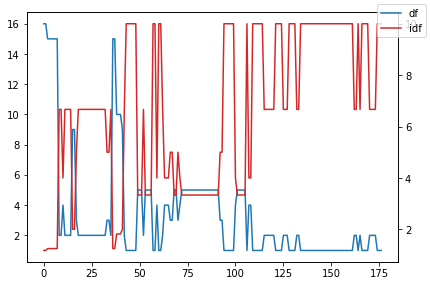

In [15]:
fig, ax1 = plt.subplots()
ax1.plot(x,df,label='df')

ax2=ax1.twinx()
ax2.plot(x, idf, color='tab:red',label='idf')
fig.tight_layout()
fig.legend(loc='upper right')
plt.show()

# Occurence Probability Prediction model

In [16]:
class lstm_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(lstm_model, self).__init__()
        #input_dim will be sequence length
        self.lstm=nn.LSTM(1, hidden_dim, batch_first=True)
        self.fc=nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        # x = [batch_size, input_dim,1]
        out, h=self.lstm(x.unsqueeze(2))
        x = self.fc(h[0].squeeze())
        x=F.log_softmax(x.unsqueeze(0),dim=1)
        return x

In [17]:
event_pred_model=torch.load('../model/eventnum50_input10_acc86.pt')
event_pred_model.load_state_dict(torch.load('../model/eventnum50_input10_acc86_state_dict.pt'))
event_pred_model.eval()

lstm_model(
  (lstm): LSTM(1, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=50, bias=True)
)

In [18]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, num_heads=5):
        super(TransformerModel, self).__init__()
        self.output_dim=output_dim
        self.transformer = nn.TransformerEncoderLayer(d_model=output_dim, nhead=num_heads, dim_feedforward =hidden_dim,batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer, num_layers=num_layers)
        #self.fc = nn.Linear(output_dim, output_dim)

    def forward(self, x):
        # x = [batch_size, input_dim]
        #print(self.output_dim)
        #print(x)
        x=F.one_hot(x.to(torch.int64), num_classes=self.output_dim)
        # x = [batch_size, input_dim, output_dim]
        out = self.transformer_encoder(x.to(torch.float32))
        # out = [batch_size, input_dim, output_dim]
        x = F.log_softmax(out[:,-1:,:].squeeze(1).to(torch.float32), dim=1)  # 확률 분포를 위해 softmax 적용
        return x

In [19]:
event_pred_model=torch.load('../model/eventnum50_input10_acc99_transform.pt')
event_pred_model.load_state_dict(torch.load('../model/eventnum50_input10_acc99_transform_state_dict.pt'))
event_pred_model.eval()

TransformerModel(
  (transformer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
    )
    (linear1): Linear(in_features=50, out_features=20, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=20, out_features=50, bias=True)
    (norm1): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
        )
        (linear1): Linear(in_features=50, out_features=20, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Line

# Abnormal Score Calculation

In [20]:
def calculate_abnormal_score(log_data,log_patterns, event_list, tf_idf, synant_dict=None):
    num_all_log=sum(single_log[1] for single_log in log_patterns)
    ori_all_event_num=len(event_list)
    print(ori_all_event_num)
    num_all_doc=len(log_data)+2
    occurrence_porb_list=[]
    repeat_rate_list=[]
    abnormal_score_list=[]
    input_dim=10
    for file_num, single_file_data in enumerate(log_data):
        print(f'processing {file_num+1}th file of {len(log_data)} num of files')
        model_input=[]
        #event_num=find_event_num(log_parser(single_file_data[0],log_dict),event_list)
        #model_input.append(event_num)
        #date_now=single_file_data[0]['date']
        #recent_event_nums=[[date_now,event_num]]
        recent_event_nums=[]
        for single_log in single_file_data:
            single_pattern=log_parser(single_log, log_dict)
            date_now=single_log['date']
            if single_pattern==[]:continue            
            event_num=find_event_num(single_pattern,event_list)
            if event_num == None:
                # Unseen Log Pattern!
                log_patterns.append([single_pattern, 1])
                tf_idf.append(ln(ln(num_all_log)*(num_all_doc+2)))
                assert(len(log_patterns)==len(tf_idf))
                find_event,event_list = put_new_pattern_to_event_list(single_pattern, event_list, synant_dict)
                if find_event:
                    event_num=find_event_num(single_pattern,event_list)
                else:
                    # Unseen Event! Make new event
                    event_list.append([single_pattern])
                    event_num=len(event_list)
            # Event Prediction (LSTM) calculate
            if event_num>ori_all_event_num:
                occurence_probability=1.2e-6
            else:
                if len(model_input)>=input_dim:
                    input_data=torch.tensor([model_input[len(model_input)-input_dim:]],dtype=torch.float32)
                    with torch.no_grad():
                        prediction=event_pred_model(input_data)
                    occurence_probability=np.exp(prediction[0][event_num-1].item())
                    model_input=model_input[len(model_input)-input_dim+1:]
                else:
                    occurence_probability=1
            # Repeat Rate calculate
            recent_event_nums=[x for x in recent_event_nums if x[0]>date_now-timedelta(minutes=10)]
            reapeat_rate=ln((len([x for x in recent_event_nums if x[1]==event_num])+2))
            
            abnormal_score=tf_idf[find_pattern_num(single_pattern,log_patterns)-1]*(1-occurence_probability)*reapeat_rate
            occurrence_porb_list.append(occurence_probability)
            repeat_rate_list.append(reapeat_rate)
            abnormal_score_list.append(abnormal_score)
            # Update recent_event_nums and etc
            recent_event_nums.append([date_now, event_num])
            if event_num<=ori_all_event_num:
                model_input.append(event_num-1)
    print(f'average of occurence_probability is {np.average(occurrence_porb_list)} and std is {np.std(occurrence_porb_list)} and max is {np.max(occurrence_porb_list)} and min is {np.min(occurrence_porb_list)}')
    print(f'average of repeat_rate is {np.average(repeat_rate_list)} and std is {np.std(repeat_rate_list)} and max is {np.max(repeat_rate_list)} and min is {np.min(repeat_rate_list)}')
    print(f'average of abnormal_score is {np.average(abnormal_score_list)} and std is {np.std(abnormal_score_list)} and max is {np.max(abnormal_score_list)} and min is {np.min(abnormal_score_list)}')
    return occurrence_porb_list, repeat_rate_list, abnormal_score_list

In [21]:
with open('data.pkl','rb') as f:
    data=pkl.load(f)
(log_dict, synant_dict, log_patterns,event_list),(Q, sigma, delta, initialState, F_) = data
tf_idf, num_all_docs=calculate_tf_idf(log_data, log_patterns)
occurrence_prob_list, repeat_rate_list, abnormal_score_list = calculate_abnormal_score(
    log_data, log_patterns,event_list,tf_idf, synant_dict)

tf-idf of all patterns are calculated
averagae of tf-idf is 7.307225476985818 and std is 9.044412287030285, max is 10.775943747261596, min is 2.1502598621583213
average of tf is 8.26465304446208 and std is 9.241679855628224 and max is 11.61209636441463 and min is 3.0135075347943983
average of idf is 6.6090818453729705 and std is 9.258310665967919 and max is 10.0 and min is 1.1764705882352942
50
processing 1th file of 18 num of files
processing 2th file of 18 num of files
processing 3th file of 18 num of files
processing 4th file of 18 num of files
processing 5th file of 18 num of files
processing 6th file of 18 num of files
processing 7th file of 18 num of files
processing 8th file of 18 num of files
processing 9th file of 18 num of files
processing 10th file of 18 num of files
processing 11th file of 18 num of files
processing 12th file of 18 num of files
processing 13th file of 18 num of files
processing 14th file of 18 num of files
processing 15th file of 18 num of files
processing 

### Results for normal logs

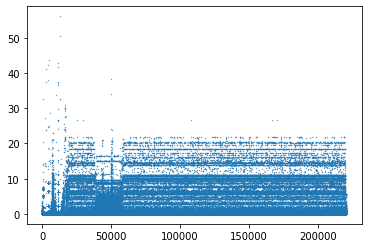

In [22]:
plt.scatter( [x for x in range(len(abnormal_score_list))], abnormal_score_list, s=0.1)

In [23]:
np.sum(np.array(abnormal_score_list)>15)

3196

In [24]:
len(abnormal_score_list)

220851

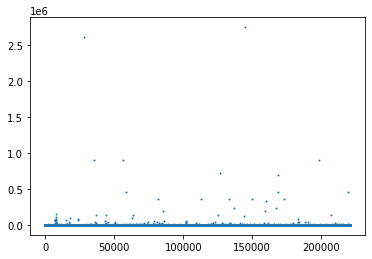

In [25]:
plt.scatter( [x for x in range(len(abnormal_score_list))], np.reciprocal(occurrence_prob_list),s=1)

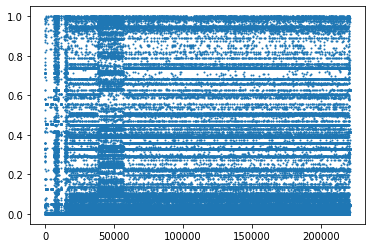

In [26]:
plt.scatter( [x for x in range(len(abnormal_score_list))],[1-x for x in occurrence_prob_list],s=1)

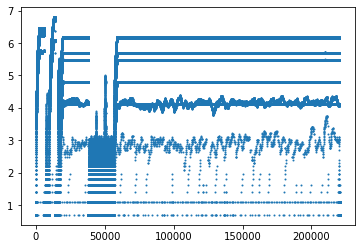

In [27]:
plt.scatter( [x for x in range(len(abnormal_score_list))], repeat_rate_list, s=1)

In [28]:
print(f'average of occurence_probability is {np.average(occurrence_prob_list)} and std is {np.std(occurrence_prob_list)} and max is {np.max(occurrence_prob_list)} and min is {np.min(occurrence_prob_list)}')
print(f'average of repeat_rate is {np.average(repeat_rate_list)} and std is {np.std(repeat_rate_list)} and max is {np.max(repeat_rate_list)} and min is {np.min(repeat_rate_list)}')
print(f'average of abnormal_score is {np.average(abnormal_score_list)} and std is {np.std(abnormal_score_list)} and max is {np.max(abnormal_score_list)} and min is {np.min(abnormal_score_list)}')

average of occurence_probability is 0.8778407240911522 and std is 0.2493279842443234 and max is 1.0 and min is 3.644154773167747e-07
average of repeat_rate is 4.708142380246298 and std is 1.3350558603369826 and max is 6.796823718274855 and min is 0.6931471805599453
average of abnormal_score is 1.6698727765881343 and std is 3.6781284285107305 and max is 56.084399049998744 and min is 0.0


## Read abnormal logs and calculate AB score

In [29]:
with open('data.pkl','rb') as f:
    data=pkl.load(f)
(log_dict, synant_dict, log_patterns,event_list),(Q, sigma, delta, initialState, F_) = data
tf_idf, num_all_docs=calculate_tf_idf(log_data, log_patterns)
# Let's calculate with abnormal Log
abnormal_log_path='../overloaded_log'
abnorm_log_data=[]
abnorm_num=0
abnorm_date_list=os.listdir(abnormal_log_path)
for date in abnorm_date_list:
    if os.path.isfile(abnormal_log_path+'/'+date):
        continue
    log_=read_file(abnormal_log_path+'/'+date+'/all.log')
    if log_:
        abnorm_log_data.append(log_)
        abnorm_num+=1
print(f'{abnorm_num} of abnormal data readed')

ab_occ_porb, ab_rep_rate, ab_ab_score= calculate_abnormal_score(abnorm_log_data, log_patterns,event_list,tf_idf, synant_dict)
with open('tf_data.pkl', 'wb')as f:
    pkl.dump((tf_idf,num_all_docs), f)

tf-idf of all patterns are calculated
averagae of tf-idf is 7.307225476985818 and std is 9.044412287030285, max is 10.775943747261596, min is 2.1502598621583213
average of tf is 8.26465304446208 and std is 9.241679855628224 and max is 11.61209636441463 and min is 3.0135075347943983
average of idf is 6.6090818453729705 and std is 9.258310665967919 and max is 10.0 and min is 1.1764705882352942
16 of abnormal data readed
50
processing 1th file of 16 num of files
processing 2th file of 16 num of files
processing 3th file of 16 num of files
processing 4th file of 16 num of files
processing 5th file of 16 num of files
processing 6th file of 16 num of files
processing 7th file of 16 num of files
processing 8th file of 16 num of files
processing 9th file of 16 num of files
processing 10th file of 16 num of files
processing 11th file of 16 num of files
processing 12th file of 16 num of files
processing 13th file of 16 num of files
processing 14th file of 16 num of files
processing 15th file of 

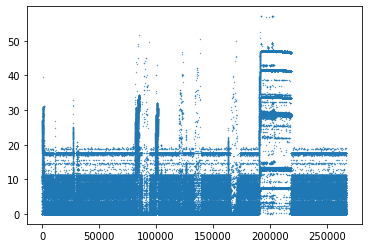

In [30]:
plt.scatter( [x for x in range(len(ab_ab_score))], ab_ab_score, s=0.1)

In [31]:
np.sum(np.array(ab_ab_score)>15)

33978

In [32]:
len(ab_ab_score)

267059

In [33]:
with open('data.pkl','rb') as f:
    data=pkl.load(f)
(log_dict, synant_dict, log_patterns,event_list),(Q, sigma, delta, initialState, F_) = data
event_list[-1:]

[[('ui', 'write', 'lostconn', 'lost', 'connection', 'to', 'peer', 'unknown')]]

In [34]:
right=0
fail=0
input_dim=10
predicted_prob=[]
for file_num, single_file_data in enumerate(log_data):
    print(f'processing {file_num+1}th file of {len(log_data)} num of files')
    model_input=[]
    for single_log in single_file_data:
        single_pattern=log_parser(single_log, log_dict)
        if single_pattern==[]:continue            
        event_num=find_event_num(single_pattern,event_list)-1
        # Event Prediction (LSTM) calculate
        if len(model_input)>=input_dim:
            input_data=torch.tensor([model_input[len(model_input)-input_dim:]],dtype=torch.float32)
            with torch.no_grad():
                prediction=event_pred_model(input_data)
            predicted_prob.append(np.exp(prediction[0][event_num].item()))
            if event_num in torch.topk(prediction,5,dim=1)[1].numpy():
                right+=1
            else:
                fail+=1
            model_input=model_input[len(model_input)-input_dim+1:]
        model_input.append(event_num)
print(np.average(predicted_prob), right/(right+fail), right+fail)

processing 1th file of 18 num of files
processing 2th file of 18 num of files
processing 3th file of 18 num of files
processing 4th file of 18 num of files
processing 5th file of 18 num of files
processing 6th file of 18 num of files
processing 7th file of 18 num of files
processing 8th file of 18 num of files
processing 9th file of 18 num of files
processing 10th file of 18 num of files
processing 11th file of 18 num of files
processing 12th file of 18 num of files
processing 13th file of 18 num of files
processing 14th file of 18 num of files
processing 15th file of 18 num of files
processing 16th file of 18 num of files
processing 17th file of 18 num of files
processing 18th file of 18 num of files
0.8777444036136757 0.9928674034901689 220677


In [ ]:
def anomaly_detection_for_file(single_log_data,log_patterns, event_list, tf_idf, synant_dict=None, threshold=[15,2], way='repeat'):
    assert(len(log_patterns)==len(tf_idf) and len(tf_idf) ==sum([len(x) for x in event_list]))
    num_all_log=sum(single_log[1] for single_log in log_patterns)
    ori_all_event_num=len(event_list)
    #print(ori_all_event_num)
    num_all_doc=len(log_data)+2
    recent_abnormal_score=[]
    input_dim=10
    model_input=[]
    recent_event_nums=[]
    abnormal_num=0
    last_abnormal=None
    for single_log in single_log_data:
        single_pattern=log_parser(single_log, log_dict)
        date_now=single_log['date']
        if single_pattern==[]:continue            
        event_num=find_event_num(single_pattern,event_list)
        if event_num == None:
            # Unseen Log Pattern!
            log_patterns.append([single_pattern, 1])
            tf_idf.append(ln(ln(num_all_log)*(num_all_doc+2)))
            #print(len(log_patterns), len(tf_idf), sum([len(x) for x in event_list]))
            assert(len(log_patterns)==len(tf_idf) )
            #print(single_pattern)
            find_event,event_list = put_new_pattern_to_event_list(single_pattern, event_list, synant_dict)
            if find_event:
                event_num=find_event_num(single_pattern,event_list)
            else:
                # Unseen Event! Make new event
                event_list.append([single_pattern])
                event_num=len(event_list)
            assert(len(tf_idf) ==sum([len(x) for x in event_list]))
        # Event Prediction (LSTM) calculate
        if event_num>ori_all_event_num:
            occurence_probability=1.2e-6
        else:
            if len(model_input)>=input_dim:
                input_data=torch.tensor([model_input[len(model_input)-input_dim:]],dtype=torch.float32)
                with torch.no_grad():
                    prediction=event_pred_model(input_data)
                occurence_probability=np.exp(prediction[0][event_num-1].item())
                model_input=model_input[len(model_input)-input_dim+1:]
            else:
                occurence_probability=1
        # Repeat Rate calculate
        recent_event_nums=[x for x in recent_event_nums if x[0]>date_now-timedelta(minutes=10)]
        reapeat_rate=ln((len([x for x in recent_event_nums if x[1]==event_num])+2))
        #print(len(tf_idf), find_pattern_num(single_pattern,log_patterns)-1)
        abnormal_score=tf_idf[find_pattern_num(single_pattern,log_patterns)-1]*(1-occurence_probability)*reapeat_rate
        if abnormal_score > threshold[0]:
            if way=='repeat':
                abnormal_num+=1
                if abnormal_num == threshold[1]:
                    #print('abnormal score consistently over!')
                    return True
            if way=='time':
                if last_abnormal:
                    if date_now-last_abnormal < timedelta(minutes=threshold[1]):
                        return True
                last_abnormal=date_now
        else:
            abnormal_num=0
        #recent_abnormal_score.append(abnormal_score)
        # Update recent_event_nums and etc
        recent_event_nums.append([date_now, event_num])
        if event_num<=ori_all_event_num:
            model_input.append(event_num-1)
    return False

In [ ]:
#Test f1 score
with open('data.pkl','rb') as f:
    data=pkl.load(f)
(log_dict, synant_dict, log_patterns,event_list),(Q, sigma, delta, initialState, F_) = data
tf_idf, num_all_docs=calculate_tf_idf(log_data, log_patterns)
ori_event_list=[x[:] for x in event_list]
f1_data={}
repeat_index=[1, 2, 3, 4,5,7,10]
for i in [16, 15, 14, 13,12]:
    print(f'single threshold is {i}')
    tmp_f1=[]
    for j in repeat_index:
        threshold=[i,j]
        tp, fp, fn, tn = 0, 0, 0, 0
        for single_file_data in log_data:
            #(log_dict, synant_dict, log_patterns,event_list),(Q, sigma, delta, initialState, F_) = data
            event_list=[x[:] for x in ori_event_list]
            if anomaly_detection_for_file(single_file_data, log_patterns[:],event_list[:],tf_idf[:], synant_dict, threshold=threshold):
                fp+=1
            else:
                tn+=1
        for single_file_data in abnorm_log_data:
            #(log_dict, synant_dict, log_patterns,event_list),(Q, sigma, delta, initialState, F_) = data
            event_list=[x[:] for x in ori_event_list]
            if anomaly_detection_for_file(single_file_data, log_patterns[:],event_list[:],tf_idf[:], synant_dict, threshold=threshold):
                tp+=1
            else:
                fn+=1
        prec=tp/(tp+fp)
        rec=tp/(tp+fn)
        print(f'thre: {j}, acc:{(tp+tn)/(tp+tn+fp+fn)}, f1: {2*prec*rec/(prec+rec)}, prec: {prec}, rec: {rec} ')
        tmp_f1.append(2*prec*rec/(prec+rec))
    f1_data[i]=tmp_f1
df=pd.DataFrame(f1_data, index=repeat_index)
df.columns.name='Repeat threshold'
df=df.rename_axis('Single threshold')
sns.heatmap(df, annot=True, cmap='Blues')

tf-idf of all patterns are calculated
averagae of tf-idf is 7.307225476985818 and std is 9.044412287030285, max is 10.775943747261596, min is 2.1502598621583213
average of tf is 8.26465304446208 and std is 9.241679855628224 and max is 11.61209636441463 and min is 3.0135075347943983
average of idf is 6.6090818453729705 and std is 9.258310665967919 and max is 10.0 and min is 1.1764705882352942
single threshold is 16
thre: 1, acc:0.7058823529411765, f1: 0.75, prec: 0.625, rec: 0.9375 
thre: 2, acc:0.6470588235294118, f1: 0.6666666666666665, prec: 0.6, rec: 0.75 


In [ ]:
f1_data=[[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5]]
repeat_index=[1, 2, 3, 4]

df=pd.DataFrame(f1_data, index=repeat_index)

In [ ]:
df.columns.name='Value threshold'
df=df.rename_axis('Repeat threshold (min)')
sns.heatmap(df, annot=True, cmap='Blues')

In [ ]:
#Test f1 score with time
with open('data.pkl','rb') as f:
    data=pkl.load(f)
(log_dict, synant_dict, log_patterns,event_list),(Q, sigma, delta, initialState, F_) = data
tf_idf, num_all_docs=calculate_tf_idf(log_data, log_patterns)
ori_event_list=[x[:] for x in event_list]
time_f1_data={}
time_index=[3,5,7,10,20]
for i in [16, 15, 14, 13,12]:
    print(f'single threshold is {i}')
    tmp_f1=[]
    for j in time_index:
        threshold=[i,j]
        tp, fp, fn, tn = 0, 0, 0, 0
        for single_file_data in log_data:
            #(log_dict, synant_dict, log_patterns,event_list),(Q, sigma, delta, initialState, F_) = data
            event_list=[x[:] for x in ori_event_list]
            if anomaly_detection_for_file(single_file_data, log_patterns[:],event_list[:],tf_idf[:], synant_dict, threshold=threshold, way='time'):
                fp+=1
            else:
                tn+=1
        for single_file_data in abnorm_log_data:
            #(log_dict, synant_dict, log_patterns,event_list),(Q, sigma, delta, initialState, F_) = data
            event_list=[x[:] for x in ori_event_list]
            if anomaly_detection_for_file(single_file_data, log_patterns[:],event_list[:],tf_idf[:], synant_dict, threshold=threshold, way='time'):
                tp+=1
            else:
                fn+=1
        prec=tp/(tp+fp)
        rec=tp/(tp+fn)
        print(f'thre: {j}, acc:{(tp+tn)/(tp+tn+fp+fn)}, f1: {2*prec*rec/(prec+rec)}, prec: {prec}, rec: {rec} ')
        tmp_f1.append(2*prec*rec/(prec+rec))
    time_f1_data[i]=tmp_f1
time_df=pd.DataFrame(time_f1_data, index=time_index)
time_df.columns.name='Value threshold'
time_df=time_df.rename_axis('Time threshold')
sns.heatmap(time_df, annot=True, cmap='Blues')

In [ ]:
normal_gradient=np.gradient(abnormal_score_list)
np.average(normal_gradient), np.max(normal_gradient), np.min(normal_gradient)

In [ ]:
plt.hist(normal_gradient,bins=20)


In [ ]:
normal_gradient.shape

In [ ]:
abnormal_gradient=np.gradient(ab_ab_score)
np.average(abnormal_gradient), np.max(abnormal_gradient), np.min(abnormal_gradient)

In [ ]:
plt.scatter( [x for x in range(len(abnormal_gradient))], abnormal_gradient, s=0.1)

In [ ]:
normal_gradient[10], normal_gradient[11], normal_gradient[12], normal_gradient[13]

In [ ]:
abnormal_score_list[10],abnormal_score_list[11], abnormal_score_list[12], abnormal_score_list[13]

In [ ]:
plt.hist(abnormal_gradient,bins=20)

In [ ]:
from scipy import stats
def calculate_confidence_interv(data):
    population_mean = np.mean(data)
    population_stddev = np.std(data, ddof=1)  # ddof=1은 자유도를 1로 설정합니다 (표본 표준편차 계산)

    # 신뢰수준과 자유도 설정
    confidence_level = 0.99
    degrees_of_freedom = len(data) - 1

    # t 분포에서의 critical value 계산
    t_critical = stats.t.ppf((1 + confidence_level) / 2, df=degrees_of_freedom)

    # 신뢰구간 계산
    margin_of_error = t_critical * (population_stddev / np.sqrt(len(data)))
    confidence_interval = (population_mean - margin_of_error, population_mean + margin_of_error)
    return confidence_interval


In [ ]:
calculate_confidence_interv(normal_gradient)

In [ ]:
calculate_confidence_interv(abnormal_gradient)

In [ ]:
np.percentile(normal_gradient, 0.01), np.percentile(normal_gradient, 99.99 )

In [ ]:
np.percentile(abnormal_score_list, 99.9 )

In [ ]:
np.percentile(ab_ab_score, 1), np.percentile(ab_ab_score, 99.9 )

In [ ]:
np.percentile(abnormal_gradient, 1), np.percentile(abnormal_gradient, 99 )

In [ ]:
from log_parser_lib import put_new_pattern_to_event_list
a=put_new_pattern_to_event_list(single_pattern, event_list, synant_dict)

In [ ]:
single_pattern=['pvidb', 'attribute', '[UNK]', 'support', '[UNK]', 'not', 'present', 'in', 'db']

In [ ]:
edit_algo=lambda x,y:edit_dist_synatn(x,y,synant_dict) if synant_dict else edit_dist

In [ ]:
edit_algo(single_pattern,single_pattern)

In [ ]:
with open('data.pkl','rb') as f:
    data=pkl.load(f)
(log_dict, synant_dict, log_patterns,event_list),(Q, sigma, delta, initialState, F_) = data
tf_idf, num_all_docs=calculate_tf_idf(log_data, log_patterns)

In [ ]:
df=pd.DataFrame(f1_data, index=repeat_index)
df.columns.name='Repeat threshold'
df=df.rename_axis('Single threshold')
sns.heatmap(df, annot=True, cmap='Blues')